# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Nejprve se zkusíme podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. Dále budeme potřebovat funkci na update všech pozic a rychlostí částic v hejnu. Také bude potřeba funkce na update nejlepšího globálního řešení. Ještě si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě. Potom už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [17]:
# nahodna inicializace hejna
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

# aktualizace hejna
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*(particle.best_position - particle.position) + phi2*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position

    return swarm

# nalezeni nejlepsiho globalniho reseni
def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

# fitness funkce
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 


# algoritmus optimalizace hejnem castic
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

   0: 4.2080
   1: 1.4744
   2: 1.0128
   3: 1.0128
   4: 1.0128
   5: 1.0128
   6: 1.0128
   7: 1.0128
   8: 1.0128
   9: 1.0028
  10: 0.9961
  11: 0.9961
  12: 0.9961
  13: 0.9961
  14: 0.9961
  15: 0.9961
  16: 0.9952
  17: 0.9952
  18: 0.9952
  19: 0.9952
  20: 0.9950
  21: 0.9950
  22: 0.9950
  23: 0.9950
  24: 0.9950
  25: 0.9950
  26: 0.9950
  27: 0.9950
  28: 0.9950
  29: 0.9950
best position
[[ 8.01846664e-05  9.95359214e-01 -4.82053867e-05  3.27581507e-04]]


Text(0.5,0,'Generace')

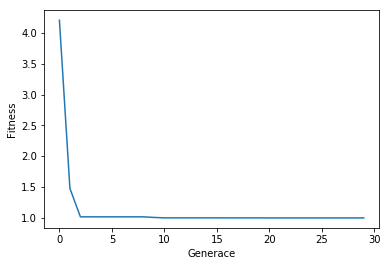

In [18]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=4, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na hledání cest v grafu. Zkusíme si s jeho pomocí vyřešit problém obchodního cestujícího, který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Implementace už je trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu nevyhodnocovat. Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [19]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

# vytvoreni reseni
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution

# hlavni kod ACO
def ant_solver(vertices, distance, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [20]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

best_solution, pheromones = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

 171, 274.1148, 299.5929, 344.8167
 172, 280.3825, 310.7696, 392.4023
 173, 277.7703, 302.3270, 320.6943
 174, 275.3207, 301.3827, 325.7168
 175, 257.3992, 306.1397, 349.8982
 176, 270.4427, 306.7162, 322.0733
 177, 236.1677, 296.8190, 324.8786
 178, 262.0263, 289.9407, 320.1094
 179, 268.9757, 294.8635, 325.0229
 180, 256.1870, 314.3762, 353.6133
 181, 262.5936, 286.0093, 320.4965
 182, 262.5936, 303.2698, 337.2589
 183, 267.5125, 296.5746, 319.6833
 184, 265.8402, 301.6697, 328.2825
 185, 284.5668, 301.9092, 320.1974
 186, 275.9249, 304.5749, 328.0970
 187, 283.5712, 304.7549, 320.1974
 188, 286.2300, 302.1508, 332.0047
 189, 289.9398, 315.3265, 382.6548
 190, 282.7205, 303.8787, 330.4999
 191, 282.7205, 307.9358, 341.2588
 192, 295.8635, 311.4618, 330.4999
 193, 287.2690, 303.0986, 325.6190
 194, 274.3946, 300.7435, 334.6898
 195, 278.5710, 302.5625, 322.8207
 196, 283.4428, 304.0718, 316.4359
 197, 247.8589, 312.4540, 348.9960
 198, 273.9055, 304.8245, 330.3726
 199, 245.3089, 301.

 408, 249.8657, 291.6141, 350.3120
 409, 253.0616, 272.1664, 298.1056
 410, 239.3488, 273.9074, 306.6167
 411, 258.4873, 285.2113, 336.5155
 412, 259.1322, 271.5529, 291.6250
 413, 253.3977, 286.0505, 344.4536
 414, 261.5855, 279.8630, 324.2498
 415, 240.4832, 279.1780, 320.8900
 416, 255.6110, 281.5271, 329.9374
 417, 259.1322, 279.4149, 314.9340
 418, 261.6692, 281.1398, 319.4865
 419, 247.3786, 263.1031, 286.4493
 420, 261.1374, 277.7016, 307.1241
 421, 259.2687, 292.4758, 328.7448
 422, 247.3786, 273.0555, 312.4973
 423, 246.5748, 268.9276, 304.5533
 424, 256.9090, 276.8694, 324.7058
 425, 259.9180, 284.1585, 353.0184
 426, 257.7199, 284.8548, 325.9893
 427, 257.7199, 270.6639, 297.9924
 428, 257.7199, 275.1588, 322.3363
 429, 259.4812, 276.4630, 304.7002
 430, 252.9353, 286.2411, 328.9316
 431, 257.8052, 273.6015, 339.9479
 432, 253.9296, 283.8627, 325.7886
 433, 247.5465, 285.5166, 323.0842
 434, 235.4251, 288.2554, 346.8084
 435, 259.0380, 277.2486, 335.3361
 436, 253.1718, 284.

 644, 249.9225, 268.3179, 295.0970
 645, 254.5634, 279.9087, 303.8044
 646, 248.4355, 273.6992, 316.2151
 647, 252.1563, 277.4101, 322.3571
 648, 250.1412, 264.8490, 279.8254
 649, 252.2462, 271.4245, 308.9142
 650, 254.2438, 277.3909, 317.8082
 651, 254.7607, 271.6739, 300.6019
 652, 260.7403, 275.9661, 309.1220
 653, 250.5665, 269.9881, 289.0204
 654, 258.9987, 286.3803, 342.0772
 655, 273.9194, 286.9623, 311.0101
 656, 255.4488, 300.5072, 364.7200
 657, 253.2747, 280.7941, 316.0737
 658, 257.0040, 286.0037, 332.4193
 659, 259.5040, 293.4868, 335.3246
 660, 246.2738, 280.3583, 325.3514
 661, 244.5466, 277.8220, 329.4453
 662, 250.8122, 275.9021, 309.3544
 663, 255.1073, 278.9800, 359.7703
 664, 249.9225, 263.5439, 283.2409
 665, 242.1889, 264.9079, 289.6681
 666, 242.1889, 284.5284, 348.6011
 667, 242.1889, 274.8688, 300.2557
 668, 242.1889, 271.9859, 346.5230
 669, 246.2738, 271.6012, 317.6827
 670, 251.5185, 296.7573, 378.0389
 671, 246.2738, 266.4976, 304.3618
 672, 246.6991, 270.

 880, 245.2664, 287.1570, 358.0919
 881, 264.5995, 290.7544, 325.7618
 882, 242.7878, 265.4851, 303.8778
 883, 254.5530, 284.4559, 324.3927
 884, 254.5530, 272.6680, 318.0749
 885, 242.7878, 267.2014, 300.0302
 886, 257.3812, 285.4136, 317.8154
 887, 242.7878, 279.4399, 347.0995
 888, 242.7878, 278.2915, 323.2780
 889, 242.7878, 288.6352, 350.4351
 890, 242.7878, 296.4664, 340.8284
 891, 256.4205, 283.3312, 349.2598
 892, 242.7878, 280.5818, 359.0661
 893, 258.6632, 277.1849, 300.6641
 894, 260.3150, 290.2723, 318.5401
 895, 254.3097, 287.1923, 327.7120
 896, 242.7878, 278.2496, 302.4638
 897, 252.0986, 271.9597, 314.8561
 898, 250.3167, 276.7519, 323.5978
 899, 262.2343, 277.1553, 313.0456
 900, 247.2627, 270.7301, 297.9862
 901, 246.6009, 264.2897, 311.4493
 902, 242.7878, 271.3188, 289.1200
 903, 253.4298, 277.1216, 330.2759
 904, 242.7878, 266.9639, 309.9505
 905, 249.7506, 272.5526, 309.9481
 906, 259.8225, 282.1046, 306.8579
 907, 250.4128, 278.5660, 317.4762
 908, 250.0007, 282.

1115, 253.5319, 275.5353, 332.1616
1116, 245.1926, 284.6806, 337.3799
1117, 261.9982, 276.6205, 332.4707
1118, 246.6067, 270.8445, 311.7613
1119, 242.1146, 271.3410, 322.6809
1120, 246.3764, 271.0722, 295.5630
1121, 244.2431, 266.6619, 302.9963
1122, 242.4338, 260.1427, 285.8945
1123, 242.1146, 272.7328, 302.4740
1124, 245.2947, 281.7996, 349.3679
1125, 242.1146, 269.1126, 306.9494
1126, 252.7987, 268.7537, 292.2101
1127, 242.7878, 277.3258, 321.3421
1128, 245.2947, 280.8464, 315.3933
1129, 251.0643, 276.8222, 344.6747
1130, 242.1146, 277.3796, 331.0877
1131, 252.5521, 286.0980, 325.1752
1132, 239.3682, 266.7099, 351.1322
1133, 240.3386, 285.0289, 340.6327
1134, 239.3682, 258.6143, 279.4153
1135, 242.3291, 279.5677, 338.0894
1136, 242.1146, 274.3336, 361.7005
1137, 242.1146, 283.1611, 397.5433
1138, 250.7831, 293.1310, 342.7603
1139, 242.1146, 278.9038, 352.2629
1140, 242.1146, 275.9911, 313.0566
1141, 242.1146, 278.5982, 336.1035
1142, 258.5347, 284.0478, 326.4773
1143, 257.6351, 276.

1352, 267.7421, 283.6811, 296.9288
1353, 254.2337, 274.7677, 313.7851
1354, 249.4662, 288.9805, 348.6805
1355, 255.0781, 276.6420, 303.2101
1356, 253.7161, 285.1271, 313.2549
1357, 253.0888, 290.1841, 326.9926
1358, 256.7598, 283.2547, 328.5032
1359, 253.0888, 286.8296, 364.0733
1360, 255.0781, 291.9658, 343.1792
1361, 253.7494, 285.3163, 324.5716
1362, 254.2406, 277.4607, 300.0296
1363, 256.9263, 287.1742, 336.9303
1364, 259.2655, 284.1787, 327.1668
1365, 251.8849, 271.8256, 341.2123
1366, 253.3241, 279.8481, 323.5605
1367, 265.9238, 313.0738, 384.5022
1368, 256.6645, 282.5613, 304.0561
1369, 253.7494, 270.2974, 291.6941
1370, 251.9363, 278.3308, 311.9163
1371, 253.7994, 268.6806, 295.8032
1372, 253.7994, 279.6297, 314.8485
1373, 249.5498, 285.6461, 354.0877
1374, 253.6963, 270.4058, 286.4417
1375, 266.3410, 278.2160, 302.3829
1376, 255.8656, 271.6197, 300.9427
1377, 250.5550, 264.0065, 300.4617
1378, 251.1506, 282.3307, 349.6284
1379, 251.1506, 267.6913, 295.4866
1380, 239.4323, 270.

1587, 231.8854, 251.5551, 309.8950
1588, 231.8854, 269.5029, 335.5187
1589, 242.2373, 262.3594, 287.8319
1590, 243.3504, 278.7646, 345.2676
1591, 233.8558, 268.7659, 307.8769
1592, 233.8558, 262.3784, 290.5633
1593, 236.1510, 254.2755, 286.2111
1594, 235.8647, 257.7318, 311.0925
1595, 242.1375, 261.5291, 298.9978
1596, 240.7863, 265.7306, 295.7115
1597, 231.9354, 270.8100, 337.7352
1598, 231.9354, 266.5399, 307.6742
1599, 231.9354, 266.0289, 314.6844
1600, 253.2898, 278.9554, 311.4849
1601, 239.3940, 268.4902, 329.6979
1602, 240.7620, 272.2340, 312.3770
1603, 240.7620, 264.4643, 327.5687
1604, 238.3994, 260.6139, 329.9263
1605, 232.9030, 252.3819, 282.2822
1606, 232.9030, 259.0184, 294.9669
1607, 233.1632, 259.0049, 275.3156
1608, 231.9354, 264.6408, 305.8470
1609, 246.5483, 269.7417, 312.7097
1610, 232.9030, 263.2424, 296.4831
1611, 231.9354, 272.0196, 320.8535
1612, 231.9354, 259.5804, 298.4965
1613, 245.4443, 263.0600, 290.3529
1614, 245.0441, 271.7201, 339.8537
1615, 246.2439, 278.

1824, 242.4931, 271.3974, 315.7746
1825, 253.8562, 279.9305, 304.7982
1826, 232.0374, 259.5591, 302.2714
1827, 235.8540, 259.4777, 305.1331
1828, 233.7749, 262.7543, 318.5119
1829, 232.0374, 263.8488, 310.7867
1830, 238.3994, 269.7800, 316.1474
1831, 234.4552, 261.1759, 281.7858
1832, 235.5029, 259.1633, 282.5361
1833, 235.5029, 259.5093, 299.1840
1834, 235.5029, 265.4071, 332.8557
1835, 237.5880, 262.2684, 306.1427
1836, 233.1006, 269.8441, 346.6542
1837, 240.9844, 262.4793, 309.4322
1838, 232.6187, 271.9076, 315.2533
1839, 232.3084, 264.8741, 310.0363
1840, 233.2216, 260.3233, 344.3938
1841, 236.9810, 277.3768, 324.1091
1842, 230.0175, 252.0369, 288.0013
1843, 233.9480, 270.0746, 343.4013
1844, 232.6437, 280.7968, 337.6679
1845, 231.8704, 262.4884, 294.4580
1846, 230.0175, 273.3252, 328.7210
1847, 230.1552, 265.0342, 297.8457
1848, 230.0175, 268.2257, 317.1160
1849, 233.3495, 264.6414, 305.2968
1850, 233.3495, 256.1030, 285.3654
1851, 232.6437, 251.1563, 271.1374
1852, 230.6024, 267.

2061, 234.7874, 266.8758, 321.2944
2062, 232.7157, 260.3050, 333.2376
2063, 232.7157, 268.3118, 339.9424
2064, 240.4565, 285.7397, 330.5318
2065, 245.5911, 276.9847, 316.2429
2066, 240.0270, 270.4775, 304.3341
2067, 247.7593, 272.0162, 314.7631
2068, 232.7157, 265.7260, 304.0337
2069, 232.7157, 263.7336, 299.3343
2070, 235.0002, 272.8297, 313.7273
2071, 243.0659, 273.6779, 330.3962
2072, 241.6922, 282.0605, 354.1139
2073, 243.0659, 270.7485, 309.9945
2074, 240.8725, 272.8012, 310.0058
2075, 235.5898, 279.3368, 332.9791
2076, 236.3737, 271.0726, 321.6369
2077, 255.9899, 270.5167, 288.9270
2078, 236.3737, 266.2324, 296.8090
2079, 236.3737, 263.5349, 302.7510
2080, 244.9605, 264.6634, 283.7071
2081, 233.1632, 261.1308, 298.9433
2082, 248.2970, 276.3628, 321.7094
2083, 238.0880, 288.3071, 342.2443
2084, 254.9199, 283.5328, 338.1467
2085, 238.0880, 268.0897, 339.3337
2086, 244.1225, 277.1566, 328.3897
2087, 254.8544, 285.5621, 323.0354
2088, 234.8230, 268.5738, 321.8136
2089, 234.9835, 263.

2297, 240.1797, 285.5382, 362.1590
2298, 249.7763, 277.5363, 305.2423
2299, 245.7200, 292.8865, 361.1872
2300, 240.6339, 273.9541, 316.6218
2301, 250.0472, 279.1564, 301.0623
2302, 240.6339, 278.5599, 306.5717
2303, 242.0504, 274.8688, 328.4107
2304, 254.2194, 284.6114, 336.8233
2305, 239.2677, 255.1013, 273.2410
2306, 240.6339, 281.0677, 322.7566
2307, 244.2573, 294.3353, 349.5194
2308, 240.6339, 270.2956, 329.3596
2309, 252.8127, 285.9317, 343.4615
2310, 240.6339, 270.8161, 299.7440
2311, 240.6339, 283.7590, 309.9444
2312, 243.1488, 274.4984, 329.5949
2313, 240.6339, 275.4259, 336.2513
2314, 240.6339, 259.9722, 300.8797
2315, 240.6339, 272.8957, 308.9768
2316, 240.6339, 272.5851, 313.5425
2317, 240.6339, 270.5719, 309.6530
2318, 240.6339, 264.6683, 293.6277
2319, 240.6339, 293.1214, 338.0738
2320, 251.6197, 292.0792, 329.0112
2321, 240.6339, 282.6820, 323.3962
2322, 243.9716, 266.0374, 287.7040
2323, 241.0156, 281.4878, 299.3437
2324, 241.0156, 292.7968, 370.0177
2325, 268.1138, 293.

2532, 233.8083, 270.8291, 300.1256
2533, 239.9443, 279.1105, 329.1868
2534, 261.2685, 298.9182, 384.9425
2535, 233.8083, 259.6471, 289.9793
2536, 233.8083, 268.8613, 307.7311
2537, 233.8083, 276.1544, 326.3856
2538, 236.5802, 269.0933, 316.8647
2539, 246.9229, 267.5083, 287.0792
2540, 257.8579, 290.6988, 332.6209
2541, 234.6058, 273.8008, 337.4230
2542, 237.5275, 267.5190, 330.2363
2543, 248.0881, 278.5761, 305.8439
2544, 239.5173, 260.7461, 285.2782
2545, 233.8083, 282.6053, 353.4246
2546, 239.4874, 276.7491, 341.0642
2547, 237.5275, 262.7335, 310.2248
2548, 256.5539, 269.7115, 296.0736
2549, 248.5634, 276.7116, 318.9505
2550, 234.6813, 260.2093, 307.9474
2551, 234.6813, 257.6319, 311.4055
2552, 236.9180, 259.8082, 299.2853
2553, 246.0275, 274.4562, 328.2826
2554, 236.9180, 270.1404, 319.0494
2555, 239.3971, 281.4841, 311.6749
2556, 234.1317, 272.8961, 318.8174
2557, 233.5815, 274.8767, 340.9436
2558, 236.9180, 266.9297, 306.8531
2559, 233.8929, 253.4793, 283.8163
2560, 234.1317, 257.

2767, 246.9757, 280.5096, 304.1967
2768, 253.5138, 285.3025, 339.2910
2769, 253.5138, 293.3992, 324.8185
2770, 246.9757, 281.6342, 314.5900
2771, 246.9757, 283.9759, 311.0983
2772, 256.3457, 286.9378, 310.9125
2773, 257.1348, 283.9642, 311.6669
2774, 268.3028, 294.5343, 376.4925
2775, 248.2832, 297.5819, 395.3658
2776, 251.1613, 287.0016, 372.8641
2777, 258.1805, 289.7531, 321.5015
2778, 253.6387, 311.3247, 369.4562
2779, 259.2711, 288.4322, 341.4573
2780, 269.7444, 305.7516, 335.4494
2781, 277.1684, 310.7828, 343.5073
2782, 277.5868, 307.8828, 340.3839
2783, 305.9242, 319.1458, 339.8909
2784, 293.8236, 315.5029, 334.7490
2785, 268.5701, 306.6714, 334.9765
2786, 267.4730, 315.2423, 354.9306
2787, 284.6660, 314.8210, 358.6633
2788, 273.5447, 310.5669, 337.8552
2789, 284.6660, 315.7817, 352.7381
2790, 288.4614, 321.4547, 349.9868
2791, 247.2919, 316.0384, 358.5948
2792, 299.4978, 322.9643, 342.8748
2793, 297.5621, 318.4609, 371.4596
2794, 282.3242, 307.5857, 318.4780
2795, 287.0872, 307.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení.

Fitness:  228.8318291609108
[Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Madrid', x=-3.7, y=40.41666667),
 Vertex(name='Lisbon', x=-9.133333333, y=38.71666667),
 Vertex(name='London', x=-7.0, y=51.5),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Oslo', x=10.75, y=59.9),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Ver

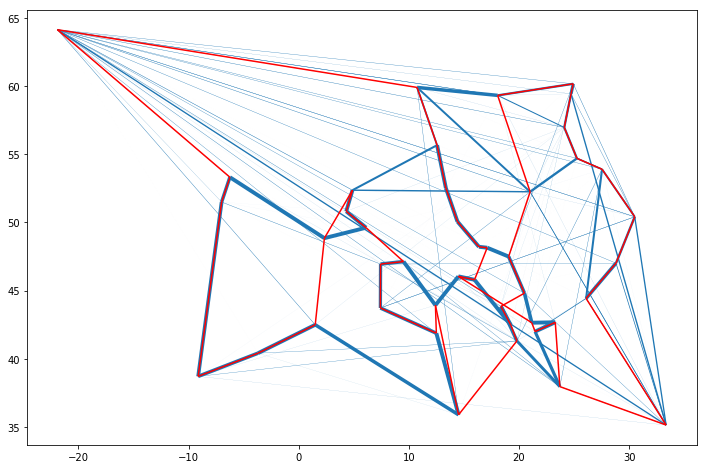

In [21]:
# vykreslime modre feromon, tloustka cary ukazuje mnozstvi feromonu na hrane
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

# vypiseme fitness reseni
print('Fitness: ', fitness(vertices, distance, solution))

# vypiseme primo poradi mest
solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

# vykreslime cervene reseni
solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])

solutions_lc = mc.LineCollection(solution_lines, colors='red')

ax.add_collection(solutions_lc)

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).


## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Zkuste si ji tedy naimplementovat ve zbytku cvičení a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic.

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezeně vozidel jednoho stejného typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.


Svůj kód, popis řešení a výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline.